<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [3.9 Modeling and Simulation of a Grocery Store Checkout Operation](https://jckantor.github.io/CBE40455-2020/03.09-Refinements-to-the-Grocery-Store-Checkout-Operation.html) | [Contents](toc.html) |<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.10-Creating-Simulation-Classes.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.10-Creating-Simulation-Classes.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.10 Creating Simulation Classes

Up to this point we have been using Python generators and shared resources as the primary building block for creating simulations of complex systems. This can be very effective, particularly if the individual agents do not require access to the internal state of other agents. But there are situations where the action of an agent depends on the state or properties of another agent in the simulation. As an example, consider this discussion question from the Grocery store checkout example:

>Suppose we were to change one or more of the lanes to a express lanes which handle only with a small number of items, say five or fewer. How would you expect this to change average waiting time? This is a form of prioritization ... are there other prioritizations that you might consider?

In this case, the action a customer depends the item limit parameter associated with a checkout lane. This is a case where the action of one agent depends on a property of another. The shared resources builtin to the SimPy library provide some functionality in this regard, but how do add this to the simulations we write?

The good news is that Python offers a rich array of object oriented programming features well suited to this purpose. The SymPy documentation provides excellent examples of how to create Python objects for use in SymPy. The bad news is that object oriented programming in Python -- while straightforward compared to many other programming languages -- constitutes a steep learning curve for students unfamiliar with the core concepts.

Fortunately, since the introduction of Python 3.7 in 2018, the standard libraries for Python have included a simplified method for creating and using Python classes. Using [dataclass](https://realpython.com/python-data-classes/), it easy to create objects for SymPy simulations that retain the benefits of object oriented programming without a lot of the coding overhead. 

The purpose of this notebook is to introduce the use of `dataclass` in creating SymPy simulations. To the best of the author's knowledge, this is a novel use of `dataclass`. These notes are the only example of which the author is aware.

## 3.10.1 Installations and imports

In [2]:
!pip install sympy

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import pandas as pd
from dataclasses import dataclass

## 3.10.2 Introduction to `dataclass`

A `dataclass` creates a more specialized version of a more general Python object class. The specialization takes care of several routine things that you would otherwise have to code, such as how to create an instance of the object, how to test for equality, and other aspects. As an example, the following cell shows how to define a dataclass corresponding to a hypothetical Student object. The Student object maintains data associated with instances of a student and defines a function associated with the object.

Examine over the following 

In [101]:
# define a dataclass object
@dataclass
class Student():
    name: str
    graduation_class: int
    dorm: str
        
    def print_name(self):
        print(f"{self.name} (Class of {self.graduation_class})")

# create an instance of a student
sam = Student("Sam Jones", 2024, "Alumni")

# use the print_name method
sam.print_name()

Sam Jones (Class of 2024)


Here are just a a few essentials facts you need to use `dataclass` effectively:

* The `class` statement is standard statement for creating a new class of Python objects. The preceding `@dataclass` is an example of a Python 'decorator' that provides for a simplified implementation.
* A Python convention is that class names begin with a capital letter. In this case, `Student` is the class name.
* Following the class statement is a series of lines declaring parameters that will be used to describe a particular instance of the new class. Each paraameter is followed by type 'hint'.  If you don't know what type, or if the type could be different things, then use the keyword `any`.
* Following the parameters, write any functions or generators that you may wish to define for the new class. To access variables unique to an instance of the class, preceed the parameter name with `self`.

The next cell shows how to create a list of students, and how to iterate over a list of students.

In [102]:
# create a list of students
students = [
    Student("Sam Jones", 2024, "Alumni"),
    Student("Becky Smith", 2023, "Howard"),
]

# iterate over the list of students to print all of their names
for student in students:
    student.print_name()
    print(student.dorm)
    

Sam Jones (Class of 2024)
Alumni
Becky Smith (Class of 2023)
Howard


## 3.10.3 Grocery Store Model

Let's review our model for the grocery store checkout operations. There are multiple checkout lanes, each with potentially different characteristics. With generators we were able to implement differences in the time required to scan items. But another parameter, a limit on number of items that could be checked out in a lane, required a new global list. The reason was the need to access that parameter, something that a generator doesn't allow. 




In [125]:
from dataclasses import dataclass

# create simulation models
@dataclass
class Checkout():
    lane: simpy.Store
    t_item: float = 1/10
    item_limit: int = 25
    
    def process(self):
        while True:
            customer_id, cart, enter_time = yield self.lane.get()
            wait_time = env.now - enter_time
            yield env.timeout(t_payment + cart*self.t_item)
            customer_log.append([customer_id, cart, enter_time, wait_time, env.now]) 
            
@dataclass
class CustomerGenerator():
    rate: float = 1.0
    customer_id: int = 1
        
    def process(self):
        while True:
            yield env.timeout(random.expovariate(self.rate))
            cart = random.randint(1, 25)
            available_checkouts = [checkout for checkout in checkouts if cart <= checkout.item_limit]
            checkout = min(available_checkouts, key=lambda checkout: len(checkout.lane.items))
            yield checkout.lane.put([self.customer_id, cart, env.now])
            self.customer_id += 1
            
def lane_logger(t_sample=0.1):
    while True:
        lane_log.append([env.now] + [len(checkout.lane.items) for checkout in checkouts])
        yield env.timeout(t_sample)
    
# create simulation environment
env = simpy.Environment()

# create simulation objects (agents)
customer_generator = CustomerGenerator()

checkouts = [
    Checkout(simpy.Store(env), 1/5, 25),
    Checkout(simpy.Store(env), 1/5, 25),
    Checkout(simpy.Store(env), 1/10, 5),
    Checkout(simpy.Store(env)),
    Checkout(simpy.Store(env)),
]

# register agents
env.process(customer_generator.process())
for checkout in checkouts:
    env.process(checkout.process())  
env.process(lane_logger())

# run process
customer_log = []
lane_log = []
env.run(until=600)

Average waiting time =  3.66 minutes

Average lane queue 
lane 0    1.334833
lane 1    1.159667
lane 2    0.077000
lane 3    0.806333
lane 4    0.582000
dtype: float64

Overall aaverage lane queue 
0.7920


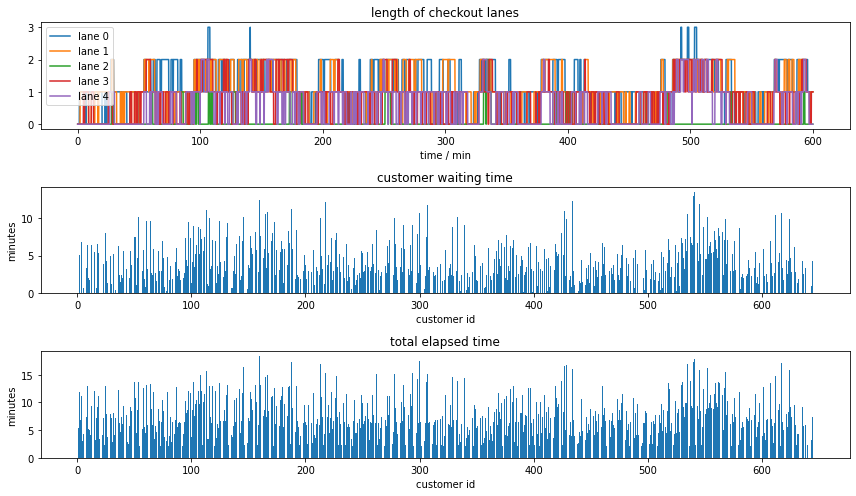

In [126]:
def visualize():

    # extract lane data
    lane_df = pd.DataFrame(lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
    lane_df = lane_df.set_index("time")

    customer_df = pd.DataFrame(customer_log, columns = ["customer id", "cart items", "enter", "wait", "leave"])
    customer_df["elapsed"] = customer_df["leave"] - customer_df["enter"]

    # compute kpi's
    print(f"Average waiting time = {customer_df['wait'].mean():5.2f} minutes")
    print(f"\nAverage lane queue \n{lane_df.mean()}")
    print(f"\nOverall aaverage lane queue \n{lane_df.mean().mean():5.4f}")

    # plot results
    fig, ax = plt.subplots(3, 1, figsize=(12, 7))
    ax[0].plot(lane_df)
    ax[0].set_xlabel("time / min")
    ax[0].set_title("length of checkout lanes")
    ax[0].legend(lane_df.columns)

    ax[1].bar(customer_df["customer id"], customer_df["wait"])
    ax[1].set_xlabel("customer id")
    ax[1].set_ylabel("minutes")
    ax[1].set_title("customer waiting time")

    ax[2].bar(customer_df["customer id"], customer_df["elapsed"])
    ax[2].set_xlabel("customer id")
    ax[2].set_ylabel("minutes")
    ax[2].set_title("total elapsed time")
    plt.tight_layout()
    
visualize()

## 3.10.4 Creating Smart Objects


Average lane queue 
lane 0    1.167000
lane 1    0.937500
lane 2    0.056500
lane 3    0.615833
lane 4    0.317333
dtype: float64

Overall average lane queue 
0.6188


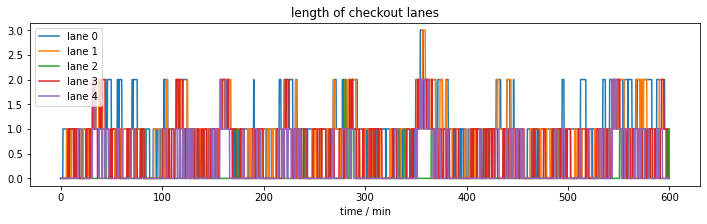

In [145]:
from dataclasses import dataclass, field
import pandas as pd

# create simulation models
@dataclass
class Checkout():
    lane: simpy.Store
    t_item: float = 1/10
    item_limit: int = 25
    
    def process(self):
        while True:
            customer_id, cart, enter_time = yield self.lane.get()
            wait_time = env.now - enter_time
            yield env.timeout(t_payment + cart*self.t_item)
            customer_log.append([customer_id, cart, enter_time, wait_time, env.now]) 
            
@dataclass
class CustomerGenerator():
    rate: float = 1.0
    customer_id: int = 1
        
    def process(self):
        while True:
            yield env.timeout(random.expovariate(self.rate))
            cart = random.randint(1, 25)
            available_checkouts = [checkout for checkout in checkouts if cart <= checkout.item_limit]
            checkout = min(available_checkouts, key=lambda checkout: len(checkout.lane.items))
            yield checkout.lane.put([self.customer_id, cart, env.now])
            self.customer_id += 1

@dataclass
class LaneLogger():
    lane_log: list = field(default_factory=list)  # this creates a variable that can be modified
    t_sample: float = 0.1
    lane_df: pd.DataFrame = field(default_factory=pd.DataFrame)
        
    def process(self):
        while True:
            self.lane_log.append([env.now] + [len(checkout.lane.items) for checkout in checkouts])
            yield env.timeout(self.t_sample)
            
    def report(self):
        self.lane_df = pd.DataFrame(self.lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
        self.lane_df = self.lane_df.set_index("time")
        print(f"\nAverage lane queue \n{self.lane_df.mean()}")
        print(f"\nOverall average lane queue \n{self.lane_df.mean().mean():5.4f}")
        
    def plot(self):
        self.lane_df = pd.DataFrame(self.lane_log, columns = ["time"] + [f"lane {n}" for n in range(0, N)])
        self.lane_df = self.lane_df.set_index("time")       
        fig, ax = plt.subplots(1, 1, figsize=(12, 3))
        ax.plot(self.lane_df)
        ax.set_xlabel("time / min")
        ax.set_title("length of checkout lanes")
        ax.legend(self.lane_df.columns)  
        
# create simulation environment
env = simpy.Environment()

# create simulation objects (agents)
customer_generator = CustomerGenerator()
checkouts = [
    Checkout(simpy.Store(env), t_item=1/5),
    Checkout(simpy.Store(env), t_item=1/5),
    Checkout(simpy.Store(env), item_limit=5),
    Checkout(simpy.Store(env)),
    Checkout(simpy.Store(env)),
]
lane_logger = LaneLogger()

# register agents
env.process(customer_generator.process())
for checkout in checkouts:
    env.process(checkout.process())  
env.process(lane_logger.process())

# run process
env.run(until=600)

# plot results
lane_logger.report()
lane_logger.plot()

<!--NAVIGATION-->
< [3.9 Modeling and Simulation of a Grocery Store Checkout Operation](https://jckantor.github.io/CBE40455-2020/03.09-Refinements-to-the-Grocery-Store-Checkout-Operation.html) | [Contents](toc.html) |<p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/03.10-Creating-Simulation-Classes.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/03.10-Creating-Simulation-Classes.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>